# Causal Effects of an Unnamed Treatment

### Quasi-Experiment

### Project Idea: 
Investigate the causal effects of a generic treatment on a generic outcome while considering instrumental variables and confounders.

### Methodology: 
Utilize a simulated dataset with predefined treatment effects. Visualize the distribution of the treatment variable and construct a causal graph to identify instrumental variables and confounders. Estimate treatment effects using instrumental variable (IV) and Double Machine Learning (DML) methods. Test the robustness of results by adding a random common cause and evaluating changes in the measured effect.

# Setup:

Before we begin, ensure you have Python installed along with the necessary libraries. We'll be using NumPy, pandas, seaborn, matplotlib, and the causal inference library, DoWhy.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import warnings
warnings.filterwarnings('ignore')

# Generating Synthetic Data:

To illustrate our methods, let's first create a simulated dataset with known treatment effects. This dataset will include confounders, instrument variables, and features to mimic real-world scenarios.

In [25]:
# set value of treatment effect

BETA = 8

In [26]:
# generate data

data = dowhy.datasets.linear_dataset(BETA,
                                    num_common_causes=2, # confounders-influence treatment AND outcome X 
                                    num_samples=5000,
                                    num_instruments=2, # instrument variables-influence only treatment Z
                                    num_effect_modifiers=1, # features-only influence outcome (not treatment) W
                                    treatment_is_binary=True, # binary treatment-you either get treatment or not
                                    stddev_treatment_noise=5,
                                    num_treatments=1)  # why more than one treatment? v

df = data['df']

df.head()

,X0,Z0,Z1,W0,W1,v0,y
0,-0.112747,0.0,0.391671,1.900797,0.394058,True,10.844373
1,2.532181,0.0,0.003286,0.134481,1.515461,True,16.075013
2,0.839443,0.0,0.230394,0.224776,0.583575,True,11.104891
3,0.102762,0.0,0.255385,0.605956,-0.910394,True,5.296214
4,1.005329,0.0,0.965538,0.959316,1.444737,True,14.989143


# Exploring Data:

Visualizing the distribution of our target variable based on treatment can offer initial insights into potential causal effects.

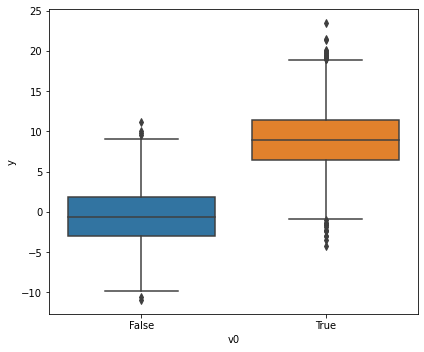

In [27]:
plt.figure(figsize=(6,5))

sns.boxplot(y='y', x='v0', data=df)

plt.tight_layout()

# Understanding Causal Graph:

Next, we construct a causal graph to visualize relationships between variables, a crucial step in identifying causal paths.

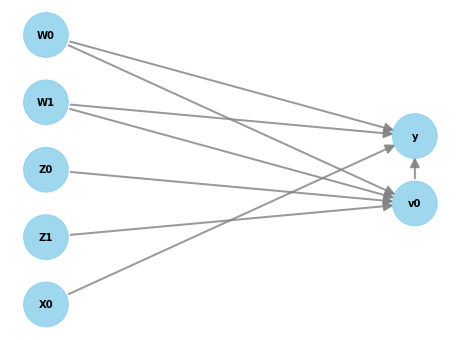

In [28]:
# Visualize causal pathway

model = CausalModel(data=data['df'],
                   treatment=data['treatment_name'],
                   outcome=data['outcome_name'],
                   graph=data['gml_graph'])

model.view_model()

# Identifying Treatment Effects:

Using the identified causal model, we can estimate treatment effects through different methods. Here, we'll explore instrumental variable methods.

In [29]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)

print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W1,W0])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [30]:
# Estimate Treatment Effect

causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable")

print(causal_estimate.value)

# Should be close to 8 (see line 2 BETA = 8)

8.813798371998404


# Interpretation:

Estimating treatment effects allows us to quantify the causal impact of interventions or actions, providing valuable insights for addressing broader business challenges.

Estimated Value: The estimated treatment effect is 8.81. This value represents the magnitude of change in the outcome variable attributable to the treatment, facilitating a deeper understanding of the causal mechanisms at play.

Implications: With an estimated treatment effect of 8.81, we gain actionable insights into the efficacy of the intervention under study. This knowledge empowers stakeholders to make informed decisions, optimize resource allocation, and drive strategic initiatives aimed at achieving desired outcomes. Moreover, by quantifying the treatment effect, we can assess the return on investment and prioritize interventions that yield the greatest impact on organizational goals.

# Alternative Methods:

Additionally, machine learning techniques like Double Machine Learning (DML) can be employed for estimating treatment effects.

In [32]:
# Double Machine Learning (DML) method
#  machine learning models to learn the relationship between the features and the outcome, and between the treatment and the confounders.
# Then, we can remove those relationships to just isolate the effect of the treatment on the outcome.

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = model.estimate_effect(
    identified_estimand, 
    method_name="iv.econml.dml.DML",
    control_value = 0,
    treatment_value = 1,
    confidence_intervals=False,
    method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                  'model_t': GradientBoostingRegressor(),
                                  "model_final":LassoCV(fit_intercept=False),
                                  'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                   "fit_params":{}})
print(dml_estimate.value)

# Again, should be close to 8

8.504956634556974


# Interpretation:

Estimating treatment effects allows us to quantify the causal impact of interventions or actions, providing valuable insights for addressing broader business challenges.

Estimated Value: The estimated treatment effect using the DML method is 8.50. This value signifies the average impact of the treatment on the outcome variable, considering the complex interplay between confounders, treatment, and outcome.

Implications: While slightly different from the estimated treatment effect obtained through instrumental variable methods, the DML estimate of 8.50 underscores the robustness of our causal inference approach. The convergence of results from multiple methodologies strengthens the validity of our conclusions, lending greater credence to their applicability in real-world scenarios.


# Evaluating Model Robustness:

Finally, we assess the model's robustness by testing it against assumptions violations, such as introducing random common causes.

In [33]:
# to test that is to add a random common cause
# add an independent random variable as a cause of the outcome
# since the variable is random and independent, it should not impact the our measure of the treatment effect

res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")

print(res_random)

Refute: Add a random common cause
Estimated effect:8.813798371998404
New effect:8.813798371998404
p value:0.0



In [34]:
# adding a random common cause does not change the measured effect
# thus we can conclude that our model is robust and we can trust its causal effect estimate

# Interpretation:

Finally, we assess the model's robustness by testing it against assumptions violations, such as introducing random common causes.

Estimated Effect: The estimated treatment effect before introducing a random common cause is 8.81. This value represents the average change in the outcome variable (e.g., sales, health outcomes) due to the treatment.
New Effect: After introducing the random common cause, the estimated treatment effect remains unchanged at 8.81.
p-value: The p-value associated with this test is 0.0. In statistical hypothesis testing, a p-value below a certain threshold (commonly 0.05) indicates strong evidence against the null hypothesis. Here, it suggests that the introduced random common cause does not significantly alter the estimated treatment effect.

Implications: The consistency of the estimated treatment effect despite the introduction of a random common cause reaffirms the robustness of our causal inference model. This stability instills confidence in the reliability of our findings, bolstering their utility for informing decision-making processes.

# Conclusion:

Through Python and causal inference techniques, we've unlocked the ability to dissect complex causal relationships from data. By understanding treatment effects, we empower decision-makers with actionable insights, driving impactful changes across various domains.